In [1]:
import scipy
import random
import portpy.photon as pp
from skimage import measure
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
import cvxpy as cp
from scipy.linalg import LinAlgError
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
import scipy.sparse
from sklearn.decomposition import PCA


In [3]:

data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_dense = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_dense = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_dense, is_full=True)
plan_dense = pp.Plan(ct, structs, beams, inf_matrix_dense, clinical_criteria)
dose_dense_1d = plan_dense.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_dense.get_num_of_fractions())
A_dense = plan_dense.inf_matrix.A
# sparse_tol = plan_sparse.inf_matrix.sparse_tol
#print(sol_sparse['problem_value'])


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Sep 11 03:24:06 PM: Your problem has 1946 variables, 110663 constraints, and 0 parameters.
(CVXPY) Sep 11 03:24:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 11 03:24:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 11 03:24:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 11 03:24:06 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------

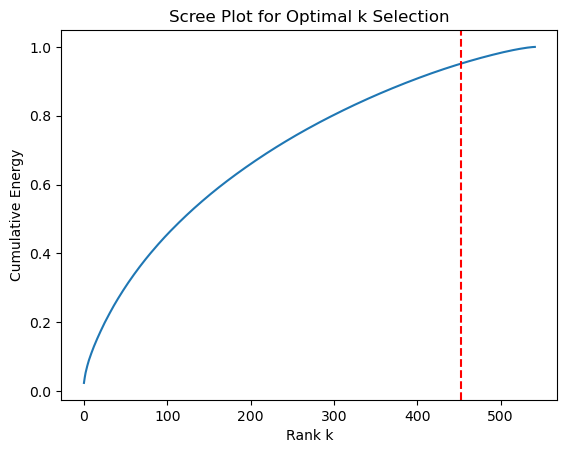

k_opt: 452


In [4]:

def optimal_k(A, threshold=0.95):
    #  SVD
    U, Sigma, VT = np.linalg.svd(A, full_matrices=False)
    #   Cumulative Energy
    cumulative_energy = np.cumsum(Sigma**2) / np.sum(Sigma**2)
    
    # Threshold
    k_optimal = np.where(cumulative_energy >= threshold)[0][0] + 1
    
    plt.plot(cumulative_energy)
    plt.xlabel('Rank k')
    plt.ylabel('Cumulative Energy')
    plt.title('Scree Plot for Optimal k Selection')
    plt.axvline(x=k_optimal, color='r', linestyle='--')
    plt.show()
    
    return k_optimal

#  Optimal k 
k_opt = optimal_k(A_dense, threshold=0.95)
print(f"k_opt: {k_opt}")


In [5]:
# PCA
pca = PCA(n_components=k_opt)
A_reduced = pca.fit_transform(A_dense)

# Inverse Transform
A_approx = pca.inverse_transform(A_reduced)

print("Original Matrix:\n", A_dense[:3])
print("Reduced Matrix (A_reduced):\n", A_reduced[:3])
print("Approximated Matrix (A_approx):\n", A_approx[:3])


Original Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reduced Matrix (A_reduced):
 [[-2.9713543e-02 -1.3995385e-03 -1.6040793e-02 ...  2.3650555e-05
   5.4605698e-06  2.5882546e-05]
 [-2.9713543e-02 -1.3995385e-03 -1.6040793e-02 ...  2.3650555e-05
   5.4605698e-06  2.5882546e-05]
 [-2.9713543e-02 -1.3995385e-03 -1.6040793e-02 ...  2.3650555e-05
   5.4605698e-06  2.5882546e-05]]
Approximated Matrix (A_approx):
 [[-5.24683855e-07 -1.11379195e-05  2.24506948e-06 ...  7.17886724e-06
  -1.60201453e-05  2.80478271e-05]
 [-5.24683855e-07 -1.11379195e-05  2.24506948e-06 ...  7.17886724e-06
  -1.60201453e-05  2.80478271e-05]
 [-5.24683855e-07 -1.11379195e-05  2.24506948e-06 ...  7.17886724e-06
  -1.60201453e-05  2.80478271e-05]]


In [6]:
rank1= np.linalg.matrix_rank(A_dense)
print(f" rank1: {rank1}")

rank2= np.linalg.matrix_rank(A_approx)
print(f" rank1: {rank2}")

 rank1: 542
 rank1: 452


In [11]:
S = A_approx.T
A = A_dense
p = dose_dense_1d
print(f'S = {S.shape}\nA = {A_dense.shape}\np = {p.shape}')

S = (542, 60183)
A = (60183, 542)
p = (60183,)


In [15]:
nonzero_count = (np.count_nonzero(A_dense))
print("nnz A Matrix: ", nonzero_count)

# Count non-zero entries in the sparsified matrix
nnz_S = (np.count_nonzero(A_approx))
print("nnz approx matrix:", nnz_S)

nnz A Matrix:  10279072
nnz approx matrix: 32619155


In [13]:
start_time = time.time()

sol_ls_S = scipy.sparse.linalg.lsqr(S @ A, S @ p )
    
end_time = time.time()
total_execution_time = end_time - start_time
print(f"LS solution time: {total_execution_time} Second")


LS solution time: 0.6002726554870605 Second


In [22]:
x_pca = sol_ls_S[0]
cost = sum_squares(S @ A @ x_pca - S @ p)
prob = Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

0.08999575212206337

<br><center> ***Minimize*** $\lVert SAx - Sp\rVert_{2}^2$

  

In [26]:
opt = pp.Optimization(plan_dense, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_dense = opt.solve(solver='MOSEK', verbose=False)

x_dense = sol_dense['optimal_intensity'] * plan_dense.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


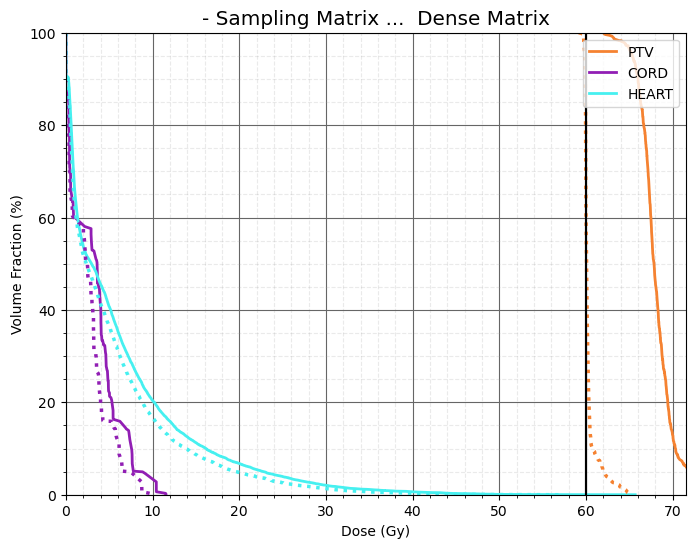

Done!


In [32]:
# DVH Plot
dose_dense = plan_dense.inf_matrix.A @ x_dense
dose_pca = plan_dense.inf_matrix.A @ x_pca 

fig, ax = plt.subplots(figsize=(8, 6))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_dense, dose_1d= dose_pca, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_dense, dose_1d=dose_dense, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- Sampling Matrix ...  Dense Matrix')
plt.savefig('DVH_Sampling.png')
plt.show()
print('Done!')

In [34]:
print("Data Type:", dose_pca.dtype)

print("Shape:", dose_pca.shape)


Data Type: float64
Shape: (60183,)


In [38]:
import pandas as pd
# Convert ndarray to DataFrame
dose_pca_df = pd.DataFrame(dose_pca)

# Describe
description = dose_pca_df.describe()

print(description)


                  0
count  60183.000000
mean       6.514755
std       12.200318
min        0.000000
25%        0.342700
50%        1.342530
75%        6.480949
max       77.726369


In [40]:
##  Analysis of matrix sparsity

is_sparse = sparse.issparse(S)
is_sparse

False

In [42]:
x_pca = sol_ls_S[0]
print(f'x :\t {x_sampling[0:6]}')

x :	 [ 5.85643076  0.31542094  1.49005179 -0.52749364 14.8839057   7.95059975]


In [44]:
sol_ls_A_Dense = scipy.sparse.linalg.lsqr(A_dense,dose_sparse_1d)
x_A_dense = sol_ls_A_Dense[0]

relative_error = np.linalg.norm(x_A_dense - x_pca) / np.linalg.norm(x_A_dense)
print(f'Relative Error:', relative_error)


Relative Error: 0.2332288405594943


In [45]:
x_A_dense= sol_ls_A_Dense[0]
print(f'x_A_dense :\t {x_A_dense[0:6]}')

cost = cp.sum_squares((A_dense @ x_A_dense  - A_dense @ x_pca  )/ cp.norm(A_dense @ x_A_dense))
prob = cp.Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

x_A_dense :	 [ 3.67488051 -1.8787341  -1.95530416 -2.43994502 12.06894575  5.92360281]


0.03074580842555681

In [46]:
# Norm Frobenius

cost = cp.norm(A_dense @ x_A_dense - A_dense @ x_sampling, "fro")/ cp.norm(A_dense @ x_A_dense, "fro")

prob = cp.Problem(cp.Minimize(cost))

prob.solve()


0.17534482719931271

In [50]:
m,n = A_dense.shape
d = m*n
a,b = S.shape
r = a*b
t,v = (S @ A).shape
f = t*v
nonzero_count = np.count_nonzero(A_dense)/d
print("nnz A Matrix: ", nonzero_count)
num_non_zero = np.count_nonzero(S @ A)/f
print("nnz SA Matrix :", num_non_zero)
nnz_S = np.count_nonzero(S )/r
print("nnz S Matrix :", nnz_S)

nnz A Matrix:  0.3151234981768092
nnz SA Matrix : 1.0
nnz S Matrix : 0.9999990496390683


In [60]:
cost = cp.sum_squares(( A_dense @ x_pca -p )/ cp.norm(p))
prob = cp.Problem(Minimize(cost))
prob.solve()

0.001288117469987998

In [62]:
## MSE 

d_true = p          # Real Dose 
d_pred = A_dense @ x_pca   # Predicted Dose  

MSE1 = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE1)


Mean Squared Error : 0.24672386928381557


In [64]:
## MSE 

d_true = A_dense @ x_A_dense            # Real Dose 
d_pred = A_dense @ x_pca   # Predicted Dose  

MSE2 = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE2)
 

Mean Squared Error : 4.349297748956522


In [68]:
r1 = np.linalg.matrix_rank(S @ A_dense) 
r2 = np.linalg.matrix_rank(A_dense)      
print( f'Rank approximation matrix = {r1}\n Rank  Dense matrix = {r2}')

Rank approximation matrix = 452
 Rank  Dense matrix = 542


In [70]:
memory_usage_sol_ls_S = sys.getsizeof(sol_ls_S )
megabyte_size_sol_ls_S = memory_usage_sol_ls_S / 1024 / 1024

print(f"Memory sol_ls_S:  {megabyte_size_sol_ls_S} MB")

Memory sol_ls_S:  0.00011444091796875 MB


In [72]:
memory_usage_S = sys.getsizeof(S)
megabyte_size_S = memory_usage_S / 1024 / 1024

print(f"Memory S : {megabyte_size_S} MB")

Memory S : 0.0001220703125 MB


In [74]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_dense)
    array2 = np.array(x_sampling)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_dense, x_sampling)
print(f"Absolute Error: {error}")


Absolute Error: 822.5391787557969


<center> 
Minimize $\lVert SAx - Sp \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>
<center>
p = دوزتجویزی
</center>


In [83]:
start_time = time.time()

# Solving the LS Problem with  Constant - x>=0
sol_sparse_con = lsq_linear (S @ A ,  S @ p, bounds=(0, np.inf))

end_time = time.time()

total_execution_time = end_time - start_time
print(f"Time to solve the problem Sol_LS: {total_execution_time} Second")


Time to solve the problem Sol_LS: 2.710179090499878 Second
